# Exploring TVB Connectivities and Models

## Setup

In [1]:
# If running in google colab, uncomment the install commands and execute this cell:

# TVB scientific library
#!pip install tvb-library

# TVB datasets
#!pip install tvb-data

In [19]:
import os,sys,glob,numpy as np,pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

from tvb.simulator.lab import *

from mpl_toolkits import mplot3d

In [11]:
# This is a utility function that gives a syntactically minimal way of writing a = np.array([a])
# (which is needed for many TVB method calls defining scalar parameters etc.)
def __(num): return np.array([num])

## Looking at connectivities

In [7]:
conn = connectivity.Connectivity.from_file();

WARNING  File 'hemispheres' not found in ZIP.


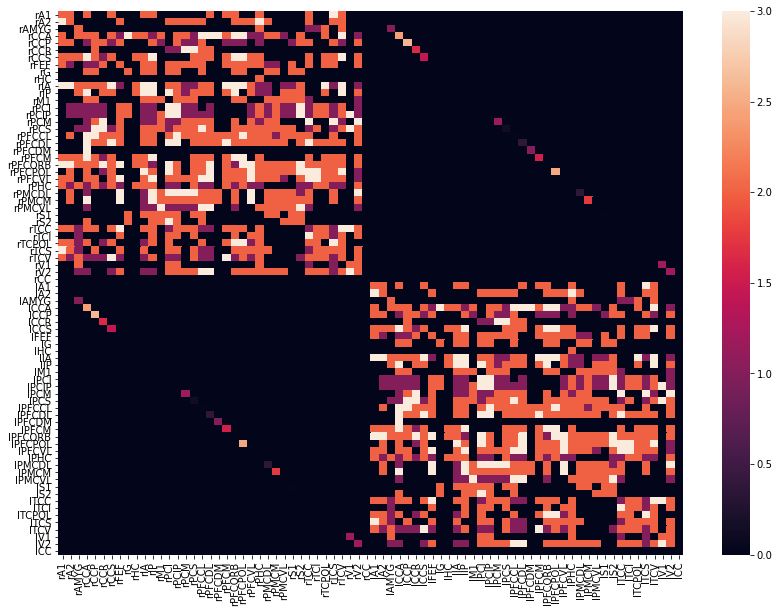

In [8]:
fig, ax = plt.subplots(figsize=(14,10))

sns.heatmap(conn.weights,xticklabels=conn.region_labels,yticklabels=conn.region_labels,ax=ax);

## Looking at models

Specify some parameters

In [12]:
# ('_sp' refers to the variable symbol as used in Spiegler et al; 
#   so as to avoid ambiguity)


gamma_sp = 1.21
epsilon_sp =  12.3083

# is this the correct? 
# - units in Spiegler are S^-1. 
# - default value for g2do d is 0.02
# - so this gives 0.07674
eta_sp = (1/1000.) * 76.74    #eta_sp = 76.74 # 1. # 76.74 ##1. # 76.74 # 1.



sp_g2do_params = dict(d = eta_sp,
                      tau = 1.,
                      f = 1.,
                      e = 0., 
                      g = -gamma_sp,
                      alpha = 1., 
                      gamma = 1., 
                      c = 0.,
                      b= -epsilon_sp, # should not be negative? LOOKS LIKE IT AL COMES DOWN TO THIS PARAM
                      beta = 0,
                      a = 0.)

sp_g2do_params = {k: __(v) for k,v in sp_g2do_params.items()}

Single node phase plane

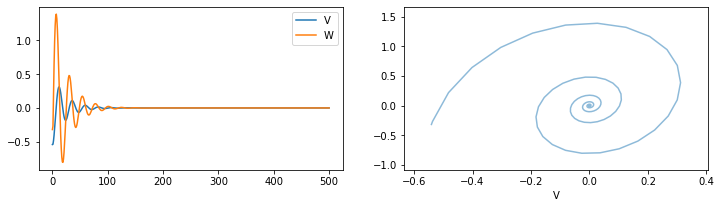

In [13]:
# Run sims

# Specify model with Spiegler parameters
sp_g2do = models.Generic2dOscillator(**sp_g2do_params)
#sp_g2do.d = (1/1000.)*eta_sp

# Evolve system for 1000 sytems, step duration 0.1ms
time,dat = sp_g2do.stationary_trajectory(n_step=5000,dt=0.1)

# Put sim results into a pandas dataframe
V_dat = np.squeeze(dat[:,0,:,:])
W_dat = np.squeeze(dat[:,1,:,:])
df_VW = pd.DataFrame([V_dat,W_dat],
                     index=['V', 'W'], 
                     columns=time).T



# Make 2 quick plots:

#f = outdir + '/pics/single_node_phase_plane_dynamics.png'

fig, ax = plt.subplots(ncols=2, figsize=(12,3))

# V and W vs. time
df_VW.plot(ax=ax[0])

# V vs. W trajectory
ymax = df_VW.W.max() + df_VW.W.std()*1.5
ymin = df_VW.W.min() - df_VW.W.std()*1.5
xmax = df_VW.V.max() + df_VW.V.std()*1.5
xmin = df_VW.V.min() - df_VW.V.std()*1.5
df_VW.plot(x='V', y='W', legend=False,ax=ax[1],
           xlim=[xmin,xmax],ylim=[ymin,ymax],alpha=0.5);

Phase space moving through a hopf bifurcation

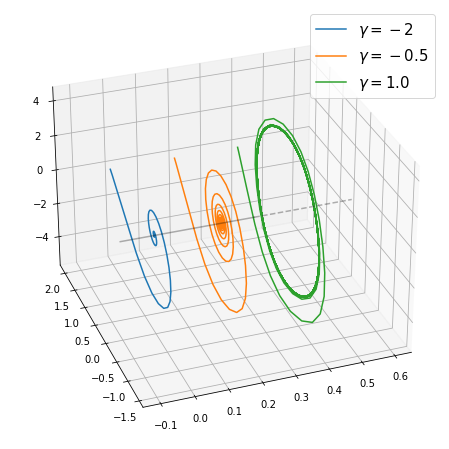

In [20]:
# First run the model for the parameter values and 
# put into a pandas dataframe

bif_params = [-2 , -0.5 ,1.]# 1.]

res = {}

for b in bif_params:

  mod = models.Generic2dOscillator(**sp_g2do_params)
  mod.g = __(b)

  initstim = np.array([2.,0.])[:,np.newaxis]
    
  time,dat = mod.stationary_trajectory(n_step=5000,dt=0.1,initial_conditions=initstim)
    
    
  V_dat = np.squeeze(dat[:,0,:,:])
  W_dat = np.squeeze(dat[:,1,:,:])
  df_VW = pd.DataFrame([V_dat,W_dat],
                       index=['V', 'W'], 
                       columns=time).T
  
  res[b] = df_VW
    

df_VWb = pd.concat(res);
df_VWb.index.names = ['g', 'time']


# Now make the 3D plot

# (note that matplotlib's 3d plotting doesn't get the order of the elements quite right
# (maybe use plotly or something to get a better version of that))

mpl.rcParams['legend.fontsize'] = 15;

fig = plt.figure(figsize=(10,8));
ax = fig.gca(projection='3d');

for b_it,b in enumerate(bif_params):

  z = df_VWb.loc[b].W.values
  y = df_VWb.loc[b].V.values
  x = np.ones(y.shape[0])*(0.2*b_it)  

  ax.plot(x,y,z, label='$\gamma = %s $' %b);#,alpha=0.5,linewidth=0.5)

    
# Draw at thick black line through the first two
# ...and  a dashed black line through the third one
ax.plot([-0.1,0.3],[0,0],[0,0],c='k', alpha=0.3);
ax.plot([0.3,0.6],[0,0],[0,0],c='k', alpha=0.3, linestyle='--');


ax.view_init(30, 250); # angle)

#ax.axis('off')
ax.legend();
plt.show();

Time series plots

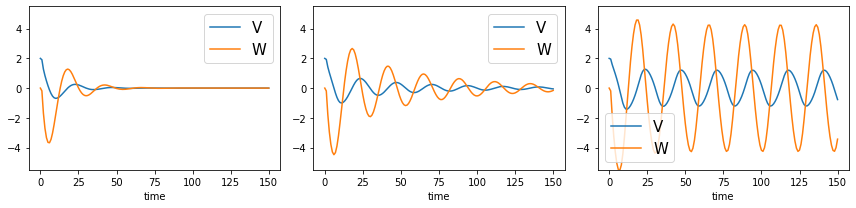

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
for b_it, b in enumerate(bif_params):  df_VWb.loc[b].loc[:150].plot(ax=ax[b_it],ylim=[-5.5,5.5])    
plt.tight_layout() 